In [1]:
import pandas as pd
import numpy as np
import os
import re
import pickle
import locale
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as Gridspec
import scipy.signal as sg
import statsmodels.api as sm
import matplotlib.dates as mdates
import itertools

from datetime import datetime, timedelta
from scipy.signal import butter, lfilter, fftconvolve, get_window, firwin2, firwin, freqz
from scipy.stats import variation, skew, kurtosis, mode
from sklearn.metrics import mean_squared_error, roc_curve, auc
from sklearn.linear_model import LinearRegression
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.svm import SVR, SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split, KFold
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from scipy import stats
from matplotlib.mlab import find
from matplotlib.gridspec import GridSpec
from statsmodels.graphics.api import qqplot
from __future__ import division
from functools import reduce

pd.set_option('max_column', 100)
pd.set_option('max_row', 4000)

%matplotlib inline

In [2]:
%run rescore.py
%run filters.py
%run coeffs_crossings.py
%run graph_sleep_wake_psg.py
%run graph_pe.py
%run graph_sleep_pred.py

## Load Data

In [3]:
def load_data(filename, samplingRate=100.0, drop_unknown=True):
    """Loads the npy file, computes for the corresponding datetime of the collected data and performs 
    bandpass filtering on the axes.
    
    Parameters
    ----------
    file: string
        npy file name
    samplingRate: float
        (default = 100.0)
    drop_unknown : boolean
        exclude unknown (0) polysomnography values
        
    Return
    ----------
    df : DataFrame
    """
    os.chdir('/Users/User/Documents/Sleep/ICHI14_data_set/data/')
    local = datetime.strptime("0001-01-01", "%Y-%m-%d")
    
    df = pd.DataFrame(np.load(filename).view(np.recarray))
    df['dtime'] = df['t'].apply(lambda x: (local + timedelta(x)).strftime('%Y-%m-%d %H:%M:%S.%f'))
    df['psg'] = df['gt']
    
    if drop_unknown:
        df = df[df['psg']!=0].reset_index(drop=True)
        
    df['z_bp'] = bandpass_filter(df['z']/4.0, 3.0, 11.0, samplingRate, 1, False)
    df['x_bp'] = bandpass_filter(df['x']/4.0, 3.0, 11.0, samplingRate, 1, False)
    df['y_bp'] = bandpass_filter(df['y']/4.0, 3.0, 11.0, samplingRate, 1, False)
    df['z_lp'] = lowpass_filter(df['z']/4.0, 10.0, samplingRate)
    
    return df

## Cole and Oakley's Sleep-Wake Algorithms using activity counts

In [4]:
def co_acti(df_):
    """Computes for the activity counts using Cole and Oakley's methods.
    Parameters
    ----------
    df_: DataFrame
        DataFrame from load_data()
    
    Return
    ----------
    df_30: DataFrame
    """
    df = df_[['dtime', 'z_bp']].copy()
    df['dtime'] = pd.to_datetime(df['dtime'])
    #Cole Activity Counts
    df_zc = df.set_index(['dtime']).resample("1S", how=zero_crossing)
    df_30 = df_zc.resample("30S", how="sum").reset_index()
    df_30.columns = ['dtime', 'ColeCounts']
    #Oakley Activity Counts
    df['z_bp'] = abs(df['z_bp'])
    df_30a = df.set_index(['dtime']).resample("1S", how="max")
    df_30['OakleyCounts'] = df_30a['z_bp'].resample("30S", how="sum").reset_index().iloc[:,1]

    return df_30


def cole_oakley(df_, threshold=20):
    """Sleep-Wake detection.
     Parameters
     ----------
     df_: DataFrame
         DataFrame from load_data()
     threshold: int
         possible values: 20 (low sensitivity), 40 (medium sensitivity), 80 (high sensitivity)
         (default=20)
         
     Return
     ----------
     df_acti: DataFrame
         Score_cole - 0 as sleep, 1 as wake
         Score_oakley - 0 as sleep, 1 as wake
     """
    df_['dtime'] = pd.to_datetime(df_['dtime'])
    df = co_acti(df_)
    df = df.set_index('dtime')
    #Cole
    df_co = pd.DataFrame(pd.rolling_apply(df['ColeCounts']
                                           , window = 7
                                           , func = cole_scoring).fillna(1), columns=['PS_Cole']).reset_index()
    df_co['Score_cole'] = df_co['PS_Cole'].apply(lambda x: 1 if (x >= 1) else 0)
    
    #Oakley
    df_co['PS_Oakley'] = pd.DataFrame(pd.rolling_apply(df['OakleyCounts']
                                           , window = 5
                                           , func = oakley_scoring).fillna(threshold+1)).reset_index().iloc[:,1]
    df_co['Score_oakley'] = df_co['PS_Oakley'].apply(lambda x: 1 if (x > threshold) else 0)
    
    #rescoring sleep-wake
    df_co['rescored_cole'] = rescored_sleep5(rescored_wake(rescored_wake2
                                                                 (rescored_sleep
                                                                  (rescore1(df_co.Score_cole)))))
    df_co['rescored_oakley'] = rescored_sleep5(rescored_wake(rescored_wake2
                                                                 (rescored_sleep
                                                                  (rescore1(df_co.Score_oakley)))))
    df_raw = df_.set_index('dtime')
    df_acti = df_co.set_index('dtime').reindex(df_raw.index, method='pad').reset_index()
    
    return df_acti


## Cole and Oakley's Sleep-Wake Algorithms using Root Mean Square(RMS)

In [5]:
def rms_padded_fn(df_, threshold=20):
    """Computes for Sleep-Wake Score by using the Root Mean Square (RMS).
    Parameters
    ----------
    df_ : DataFrame
    threshold : int
        used if fn=oakley
        
    Return
    ----------
    dfn : DataFrame
    """
    df = df_[['dtime', 'x_bp', 'y_bp', 'z_bp', 'gt']].copy()
    df['dtime'] = pd.to_datetime(df['dtime'])
    
    #amplitude of each axis
    df['x_amp'] = df['x_bp'].apply(lambda r: abs(r).max())
    df['y_amp'] = df['y_bp'].apply(lambda r: abs(r).max())
    df['z_amp'] = df['z_bp'].apply(lambda r: abs(r).max())
    
    #root mean square of the 3axis' amplitudes for each 30s epoch 
    df['rms'] = df[['x_amp', 'y_amp', 'z_amp']].apply(lambda r: np.sqrt((r**2).mean()), axis=1)
    df1 = df.copy()
    df = df.set_index('dtime')
    df_30c = pd.DataFrame(df['rms'].resample("30S", how='sum'))
    
    # zero crossings, maximum, minimum, mean, standard deviation, median, skew, kurtosis, sleep-wake score, rescoring:
    df_30 = df_30c.reset_index().copy()
    df_30['rmsCounts']  = df['rms'].resample("30S", how=signal_cut).reset_index().iloc[:,1]
    df_30['rmsMax']  = df['rms'].resample("30S", how='max').reset_index().iloc[:,1]
    df_30['rmsMin'] = df['rms'].resample("30S", how='min').reset_index().iloc[:,1]
    df_30['rmsMean'] = df['rms'].resample("30S", how='mean').reset_index().iloc[:,1]
    df_30['rmsSD'] = df['rms'].resample("30S", how='std').reset_index().iloc[:,1]
    df_30['rmsMed'] = df['rms'].resample("30S", how='median').reset_index().iloc[:,1]
    df_30['rmsSkew'] = df['rms'].resample("30S", how=skew).reset_index().iloc[:,1]
    df_30['rmsKurt'] = df['rms'].resample("30S", how=kurtosis).reset_index().iloc[:,1]
    
    #oakley
    df_30['PS_oakley_rms'] = pd.DataFrame(pd.rolling_apply(df_30c['rms']
                                                , window = 5
                                                , func = oakley_scoring).fillna(threshold+1)).reset_index().iloc[:,1]
    df_30['Score_oakley_rms'] = df_30['PS_oakley_rms'].apply(lambda x: 1 if (x > threshold) else 0)

    #cole
    df_30['PS_cole_rms'] = pd.DataFrame(pd.rolling_apply(df_30c['rms']
                                                , window = 7
                                                , func = cole_scoring_rms).fillna(1)).reset_index().iloc[:,1]
    df_30['Score_cole_rms'] = df_30['PS_cole_rms'].apply(lambda x: 1 if (x >= 1) else 0)
    
    #rescore sleep-wake values
    df_30['rescored_oakley_rms'] = rescored_sleep5(rescored_wake(rescored_wake2
                                                                 (rescored_sleep(rescore1(df_30.Score_oakley_rms)))))
    df_30['rescored_cole_rms'] = rescored_sleep5(rescored_wake(rescored_wake2
                                                           (rescored_sleep(rescore1(df_30.Score_cole_rms)))))
    
    #reindex to original length
    dfn = df_30.set_index('dtime').reindex(df.index, method='pad').reset_index()
    dfn['rms_raw'] = df1['rms']
    dfn['psg'] = df1['gt']
    dfn['x_bp'] = df1['x_bp']
    dfn['y_bp'] = df1['y_bp']
    dfn['z_bp'] = df1['z_bp']

    return dfn

In [6]:
def run_sleep_wake(fname):
    """Identifies and displays the Sleep-Wake periods and Sleep Stages derived from Cole and Oakley's methods.
    Parameters
    ----------
    fname : str
        file name
    """
    df = load_data(fname)
    print (fname[:-4])
    df_co = cole_oakley(df)
    df_rms = rms_padded_fn(df)
    df_feats = df_rms.merge(df_co, on='dtime', how='left')
    graph_sleep_wake(df, df_feats)

    return df, df_feats

In [7]:
 def process_data(lst, col='rescored_oakley_rms'):
    """Returns a list and a concatenated dataframe of sleep chunks.
    Parameter
    ----------
    lst : list
        list of filenames
    col: string
        column name- basis for the sleep chunks
    """
    store = []
    for i in lst:
        df, dfalgo = run_sleep_wake(i)
        df['uname'] = i
        store.append(dfalgo)
    df_concat = pd.concat(store)
    sleep_chunks_lst, sleep_chunks_df = sleep_chunks(df_concat, col)

    return df_concat, sleep_chunks_lst, sleep_chunks_df

In [8]:
def choose_train_test(lst):  
    """Returns the test and train sets.
    Parameter
    ----------
    lst : list
        list of dataframes
    """
    len_ = len(lst)
    testidx = np.random.choice(range(len_))
    testdata = lst[testidx]
    print ('index:', testidx)
    
    if testidx == 0:
        traindata = lst[testidx+1:]
    elif testidx == (len_ - 1):
        traindata = lst[:testidx]
    else:
        traindata = lst[:testidx]
        traindata.extend(lst[testidx+1:])
    train_concat = pd.concat(traindata)
    
    return testdata, traindata, train_concat

##cut to sleep-wake chunks

In [9]:
def sleep_chunks(df_, col='rescored_oakley_rms'):
    """Returns a list and concatenated dataframe of sleep dataframes.
    Parameter
    ----------
    df : DataFrame
        sleep-wake dataframe
    col : string
        column name- basis for the sleep chunks
    
    Return
    ----------
    df_lst : list
    df_concat : DataFrame
    """
    lst = []
    df_lst = []
    df = df_.reset_index(drop=True)
    smpl = df[col]
    for i in range(len(smpl)):
        if smpl[i] == 0:
            lst.append(i)  
    smpl_blocks = consecutive_reverse(lst, 1)
    sleep_sections = {'blck%s' %(i+1): smpl_blocks[i] for i in range(len(smpl_blocks)) if len(smpl_blocks[i]) >= 1000}
    for j in list(sleep_sections.values()):
        a, b = (j[0], j[-1])
        if a >= 250:
            df_lst.append(df[a-249:b+1])
        else:
            df_lst.append(df[a:b+1])
    
    #into one dataframe
    df_concat = pd.concat(df_lst)
    
    return df_lst, df_concat

##Permutation Entropy

In [10]:
def permutation_entropy(x, n):
    """
    x : accelerometer data
    n: int
        n>=2
    """
    T = len(x)
    permutation_dict = {str(np.array(key)):0 for key in itertools.permutations(range(n))}
    for i in range(T - n + 1):
        window = x[i:i+n]
        pi = str(np.argsort(window))
        permutation_dict[pi] += 1
   
    entropy = 0
    for pi in permutation_dict.values():
        if pi == 0:
            continue
       
        freq_pi = pi/(T-n+1)
        entropy -= (freq_pi)*np.log2(freq_pi)
   
    return entropy

In [26]:
def perm_entropy(dflst, col='z_bp', wndw=250, n=5):
    """Computes for the permutation entropy in a sliding window.
    Parameters
    ----------
    dflst : list
        returned list from sleep_chunks()
    col : str
        column name
    wndw : int
    n : int
        n >= 2
    
    Return
    ----------
    pe_lst : list
    pe_concat : DataFrame
    """
    pe_lst = []
    len_ = len(dflst)
    if isinstance(dflst, list):
        for i in range(len_):
            df = dflst[i].copy()
            pedf = pd.DataFrame(pd.rolling_apply(df[col], wndw, lambda x: permutation_entropy(x, n))
                              , columns=['pe']).reset_index()
            df['pe'] = pedf['pe'].fillna(0).values
            idxlst = df.index.values
            df = df.ix[idxlst[250]:]
            pe_lst.append(df) 
        #into one dataframe
        pe_concat = pd.concat(pe_lst)
    else:
        df = dflst.copy()
        pedf = pd.DataFrame(pd.rolling_apply(df[col], wndw, lambda x: permutation_entropy(x, n))
                          , columns=['pe']).reset_index()
        df['pe'] = pedf['pe'].fillna(0).values
        idxlst = df.index.values
        pe_concat = df.ix[idxlst[250]:]
    
    return pe_lst, pe_concat

In [12]:
def classifier_result(train, test, mdl=SVC(), feat_=[], y='psg'):
    """Returns the predicted values using the classifier specified.
    Parameter
    ----------
    train : DataFrame
        train data
    test : DataFrame
        test data
    mdl : classifier function
        sklearn classifier or other classifier function
    feat_ : list
        list of features (column names) to be used
    y : string
        labeled data/ ground truth
    """
    X_Train = train[feat_].values
    Y_Train = train[y].values
    X_Test = test[feat_].values
    clf = mdl
    clf_predicted = clf.fit(X_Train, Y_Train).predict(X_Test)
    
    return clf_predicted

## Data

In [13]:
fnames = ['p08a.npy', 'p08b.npy', 'p034.npy', 'p033.npy', 'p051.npy']
print (fnames)

['p08a.npy', 'p08b.npy', 'p034.npy', 'p033.npy', 'p051.npy']


p08a


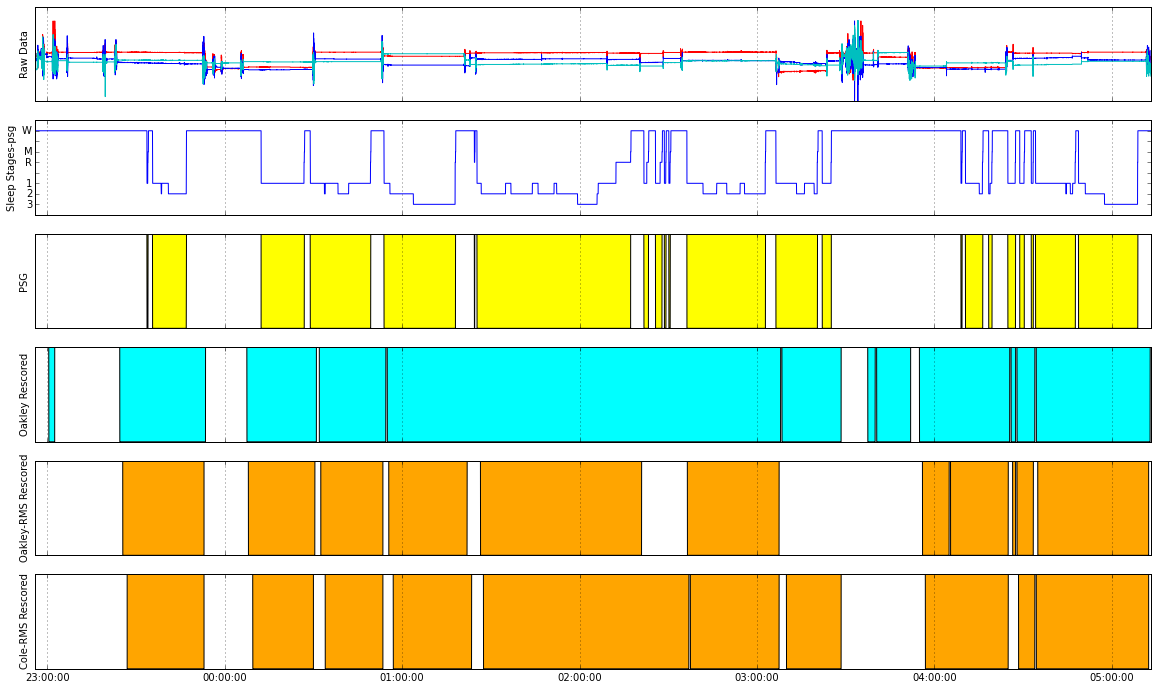

p08b


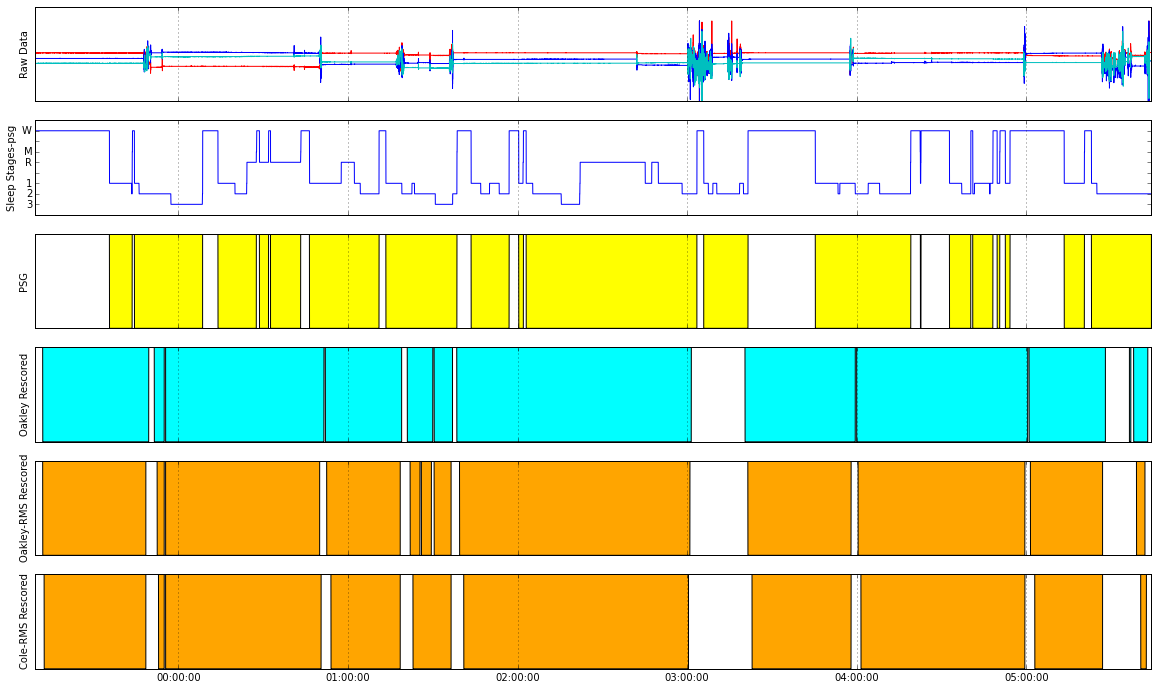

p034


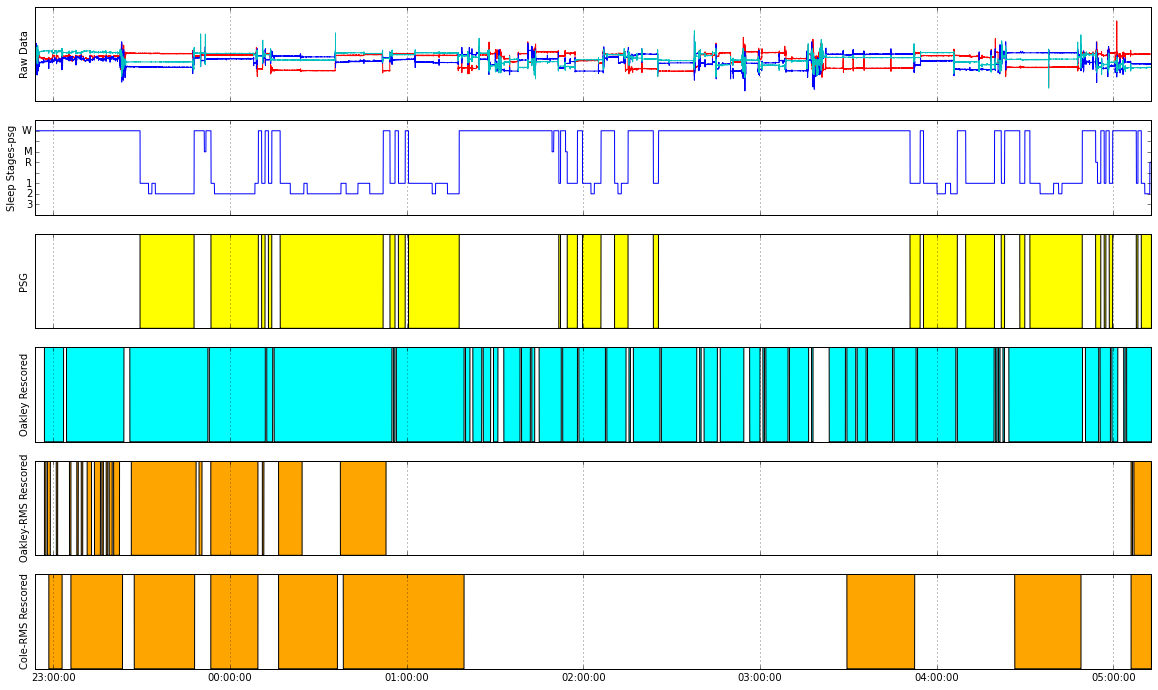

p033


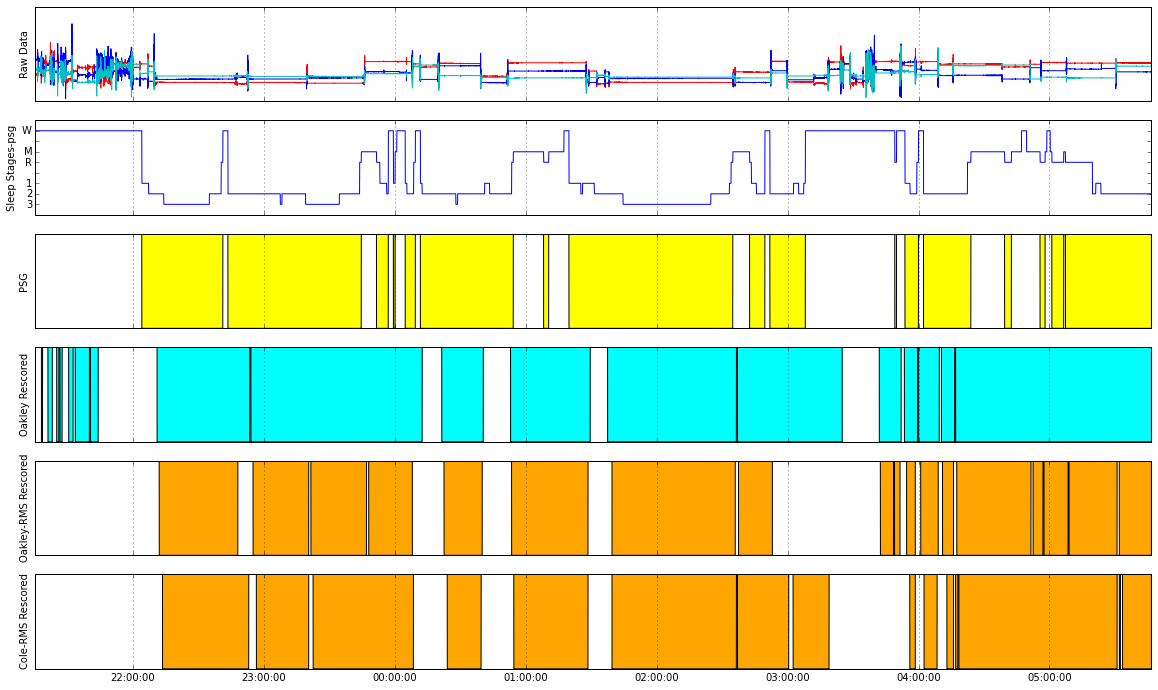

p051


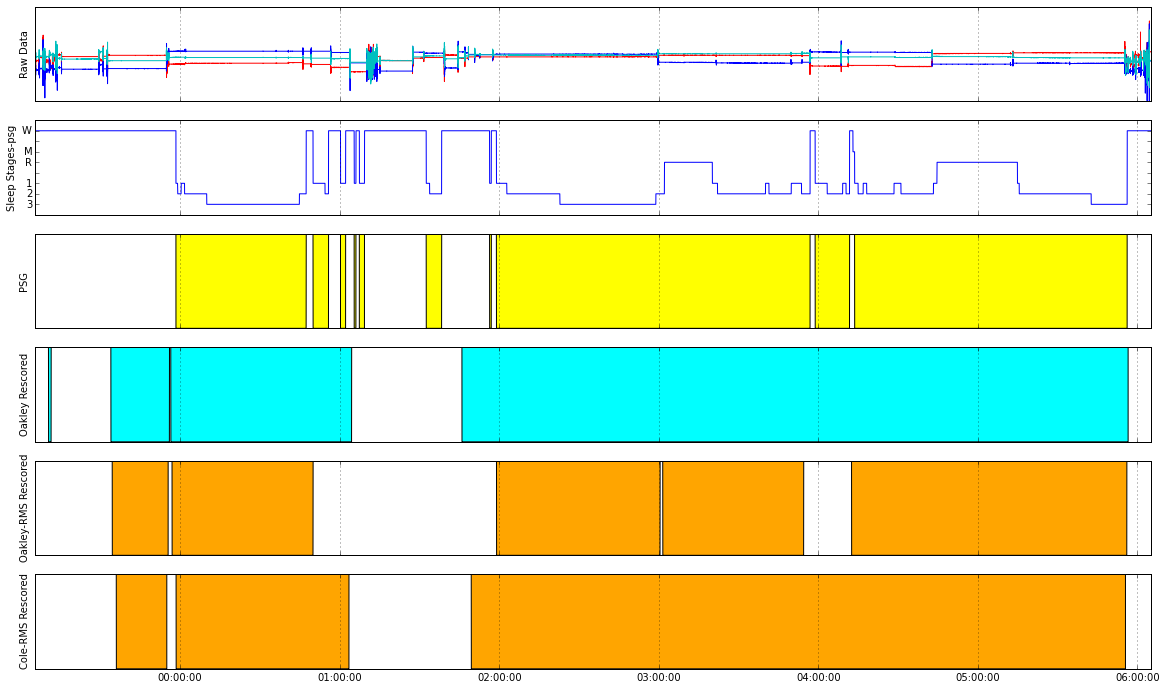

In [36]:
dtadf, sleeplst, sleepdf = process_data(fnames, col='rescored_cole_rms')

## Train-Test Data

In [37]:
testdf, trainlst, traindf = choose_train_test(sleeplst)

index: 18


## Compute Permutation Entropy

In [38]:
train_pelst, train_pedf = perm_entropy(trainlst)
test_pelst, test_pedf = perm_entropy(testdf)

In [39]:
#Descriptives
f = {'pe':['mean', 'median', 'std', 'max', 'min']}
train_pedf_gb = train_pedf.groupby(['psg']).agg(f)
train_pedf_gb

pe                                        
         mean    median       std       max       min
psg                                                  
1    3.079181  3.108688  1.270706  5.348542  0.000000
2    3.754659  3.931484  1.052113  5.506795  0.000000
3    3.861740  4.042401  0.940860  5.670231  0.000000
5    2.950326  3.269117  1.346813  5.125912  0.000000
6    4.120033  4.188178  0.622556  5.384596  1.257586
7    3.182365  3.267665  0.856624  5.250032  0.000000

## SVC

### using rescored_oakley_rms

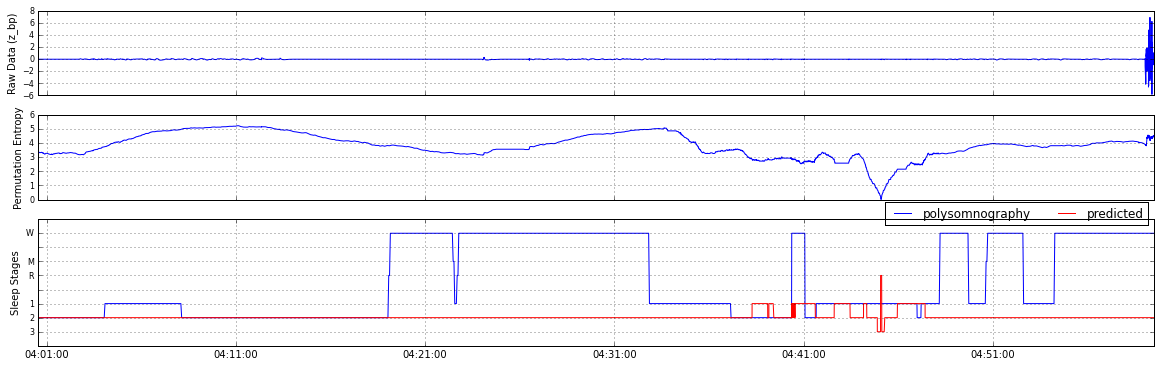

In [30]:
feat=['pe']
test_pedf['pred_svc_pe'] = classifier_result(train_pedf, test_pedf, feat_=feat)
graph_pe(test_pedf, col3='pred_svc_pe')

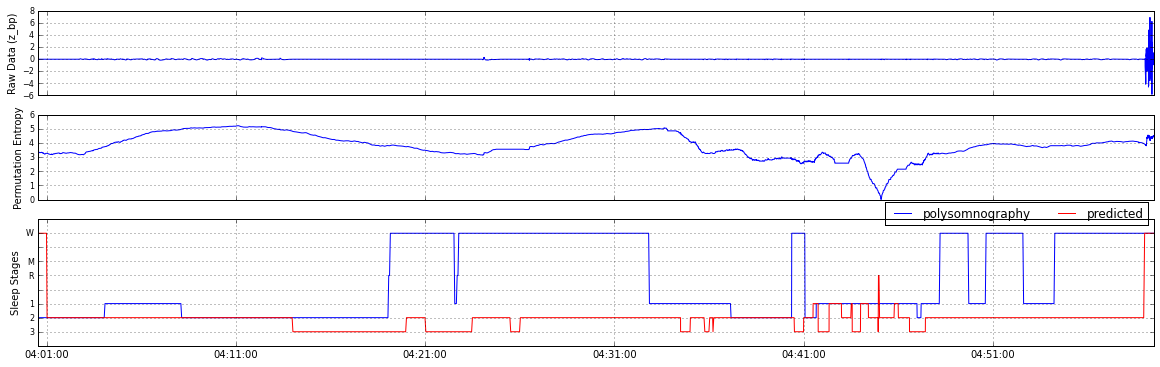

In [31]:
feat1=['rmsCounts', 'rmsMax', 'rmsMin', 'rmsMean', 'rmsSD', 'PS_cole_rms', 'rescored_cole_rms', 'pe']
test_pedf['pred_svc_sano'] = classifier_result(train_pedf, test_pedf, feat_=feat1)
graph_pe(test_pedf, col3='pred_svc_sano')

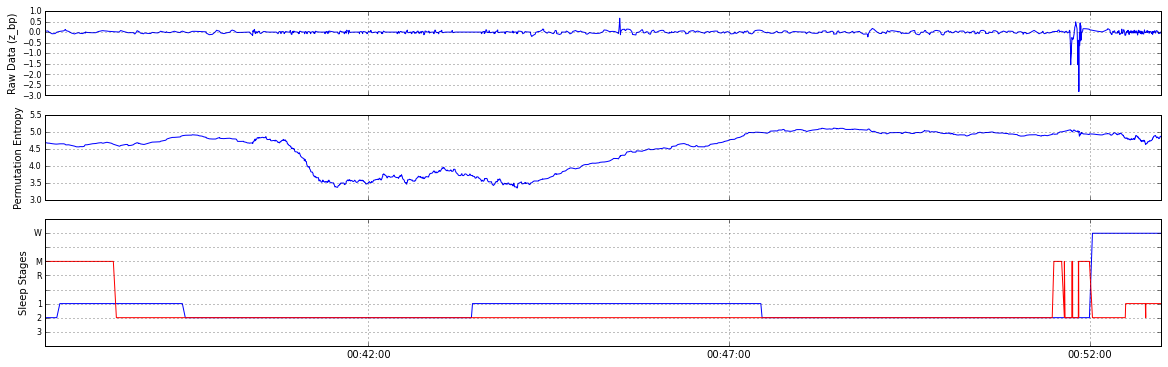

In [81]:
graph_pe(test_pedf, col3='pred_svc_sano')

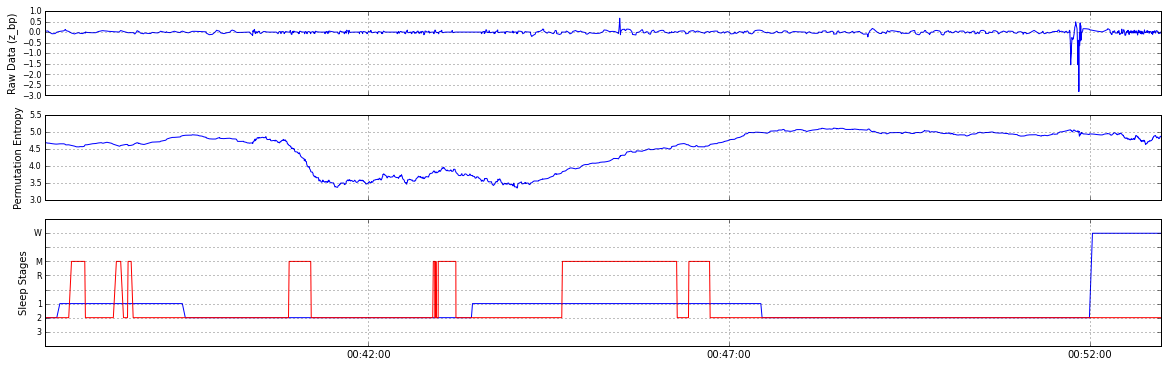

In [94]:
feat2=['pe']
test_pedf['pred_svc_pe'] = classifier_result(train_pedf, test_pedf, feat_=feat2)
graph_pe(test_pedf, col3='pred_svc_pe')

      Iter       Train Loss   Remaining Time 
         1       75185.5441           11.48s
         2       73617.2799           10.62s
         3       72339.4632           10.25s
         4       71290.3856            9.99s
         5       70423.2854            9.70s
         6       69706.1967            9.60s
         7       69095.8859            9.54s
         8       68563.2762            9.47s
         9       68070.4253            9.37s
        10       67626.5214            9.28s
        20       65346.5327            8.47s
        30       64492.6797            7.28s
        40       63938.9109            6.26s
        50       63517.4595            5.17s
        60       63177.5412            4.07s
        70       62850.4774            3.02s
        80       62569.9873            2.00s
        90       62348.6315            1.00s
       100       62131.1818            0.00s


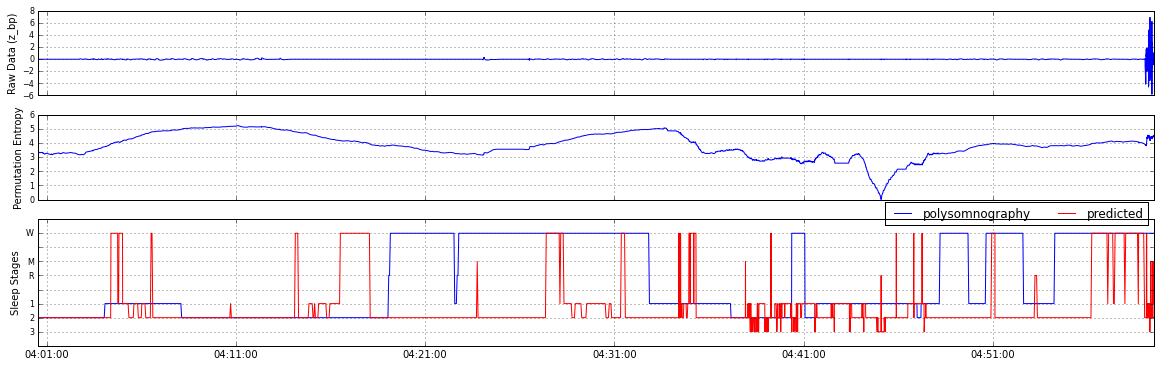

In [32]:
test_pedf['pred_gb_pe'] = classifier_result(train_pedf, test_pedf
                                            , mdl=GradientBoostingClassifier(verbose=1)
                                            , feat_=feat)
graph_pe(test_pedf, col3='pred_gb_pe')

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


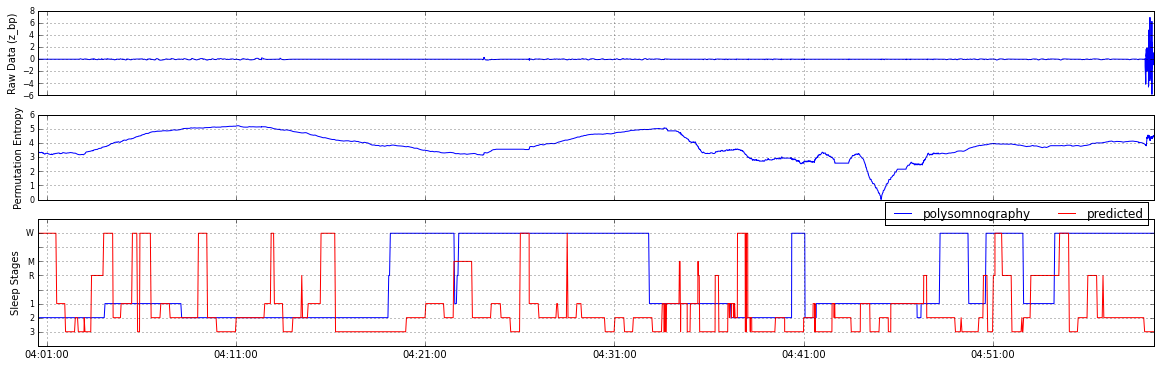

In [35]:
test_pedf['pred_et_pe'] = classifier_result(train_pedf, test_pedf
                                            , mdl=ExtraTreesClassifier(verbose=1)
                                            , feat_=feat1)
graph_pe(test_pedf, col3='pred_et_pe')

### using rescored_cole_rms

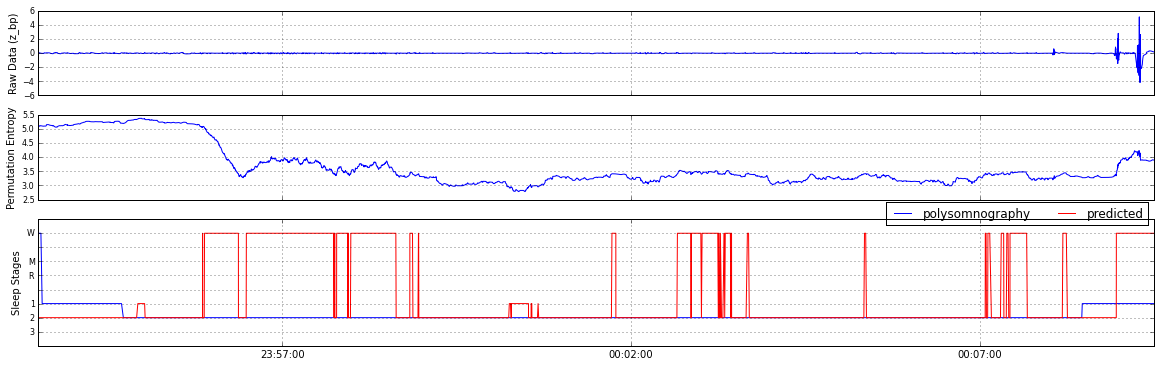

In [40]:
feat=['pe']
test_pedf['pred_svc_pe'] = classifier_result(train_pedf, test_pedf, feat_=feat)
graph_pe(test_pedf, col3='pred_svc_pe')